In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('../terrain-erosion-3-ways/')
from river_network import *

sys.path.append("../pipeline")
from svg_extraction import SVGExtractor
from svg_extraction import (
    get_city_coordinates, get_island_coordinates, get_island_centers, 
    get_orthogonal_samples, get_coast_coordinates, get_heightline_centers)
from image_ops import flood_image, flood_islands
from skimage.segmentation import flood, flood_fill
from skimage.morphology import opening, square

import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import png
import PIL

import ipywidgets as widgets
from IPython.display import display
import glob

import logging
logger = logging.getLogger()

In [26]:
paths = glob.glob("../svgs/*.svg")
paths.sort()
realm_selection = widgets.Dropdown(
    options=paths,
    description='svg:',
    disabled=False,
)
display(realm_selection)

Dropdown(description='svg:', options=('../svgs/1.svg', '../svgs/10.svg', '../svgs/100.svg', '../svgs/101.svg',…

In [36]:
config = OmegaConf.load("../pipeline/config.yaml")

# exp

In [37]:
from run import run_pipeline

INFO:realms:Setting up extractor


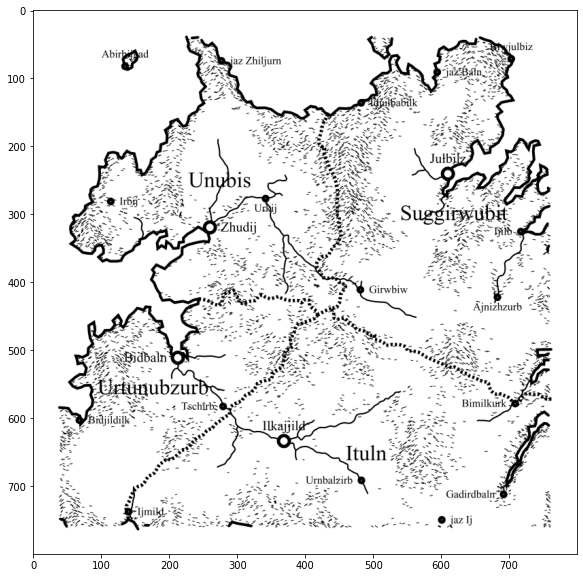

INFO:realms:    \---DONE
INFO:realms:Extracting coast
INFO:realms:    \---DONE
INFO:realms:Extracting heightlines
INFO:realms:    \---DONE
INFO:realms:Starting ground-sea mask logic


1
3
0


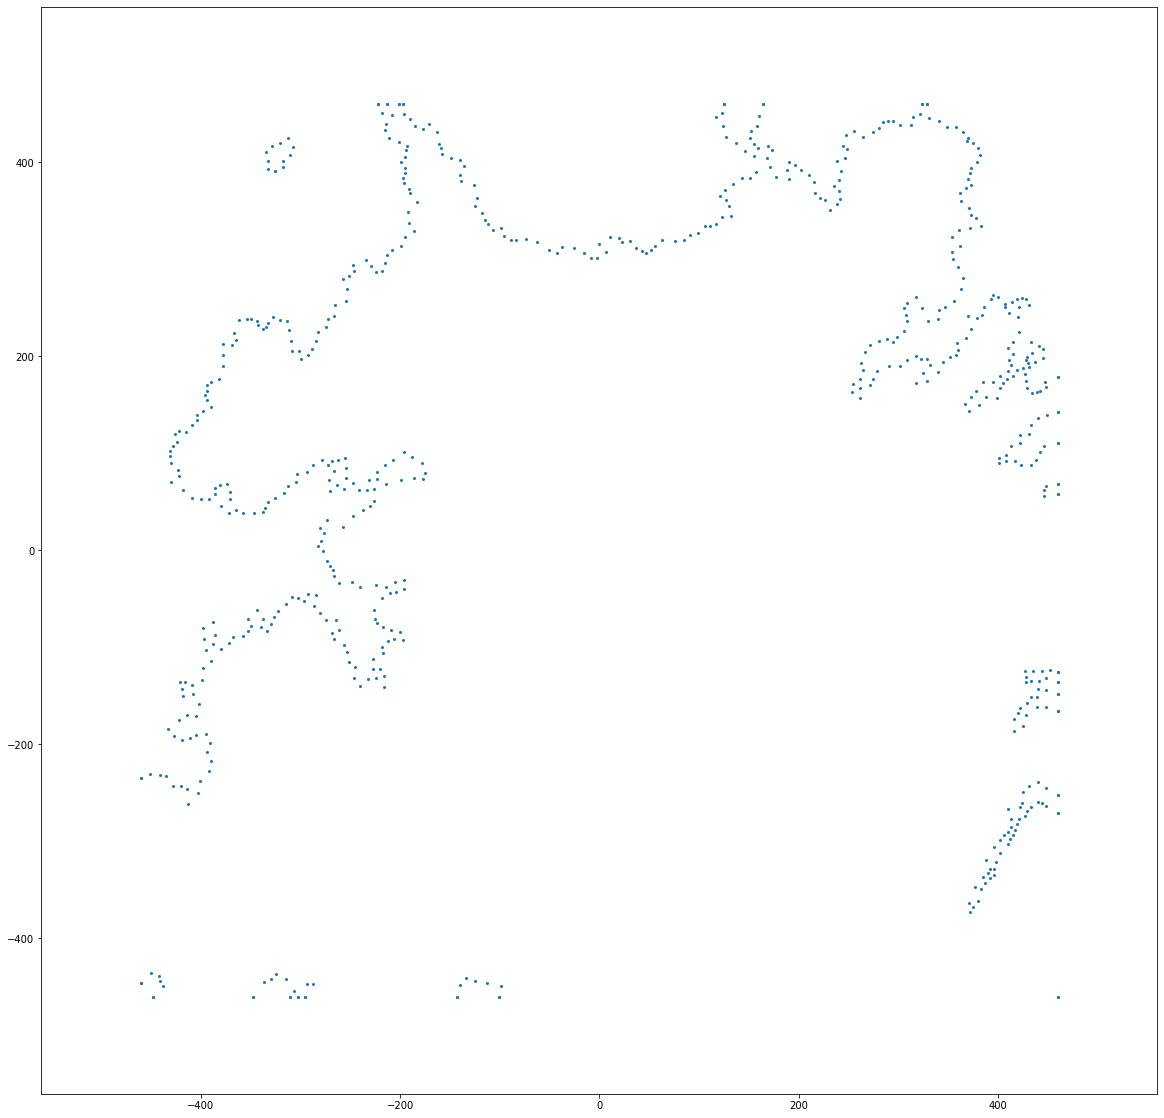

DEBUG:realms:mask_shape: (800, 800)


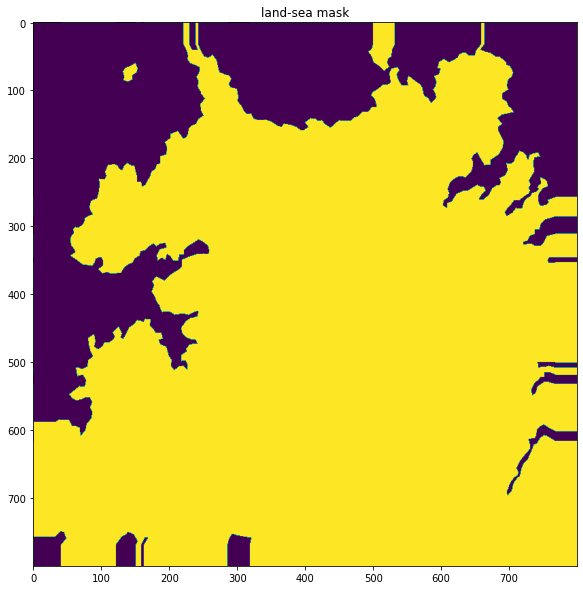

INFO:realms:    \---DONE
INFO:realms:----Extracting rivers
../pipeline/run.py:102: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  rivers = skimage.filters.gaussian(rivers, sigma=1.2)[...,0] # rivers is now [0,1]


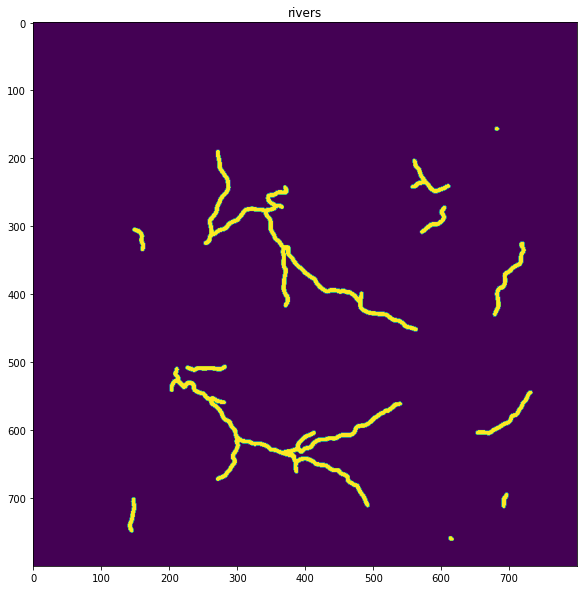

INFO:realms:    \---DONE
INFO:realms:----Combining coast and rivers


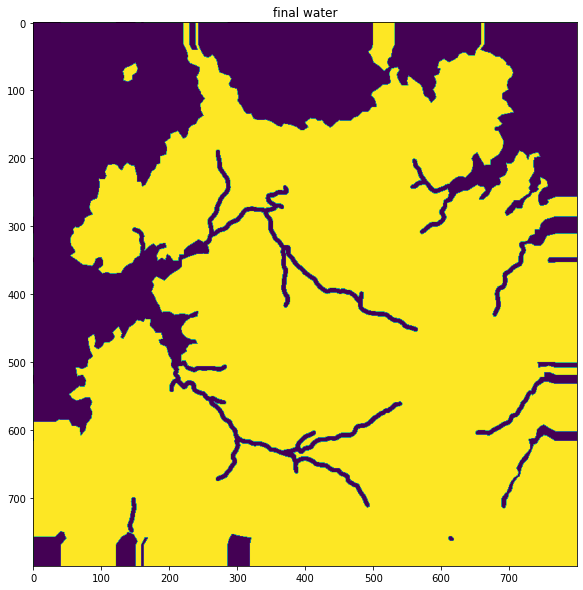

INFO:realms:    \---DONE
INFO:realms:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


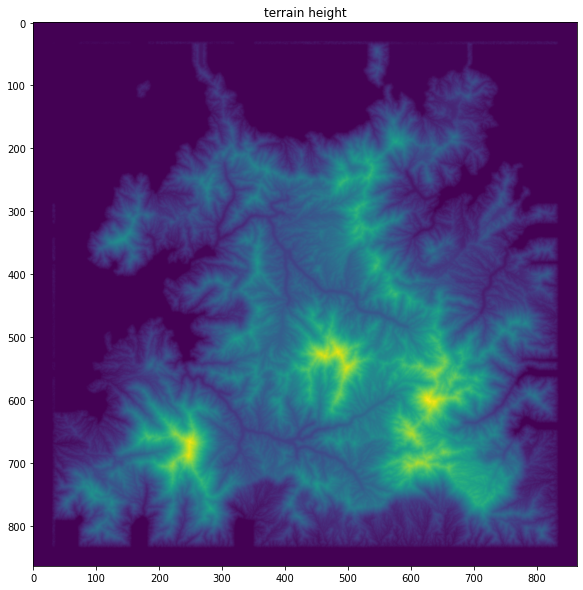

INFO:realms:    \---DONE
INFO:realms:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


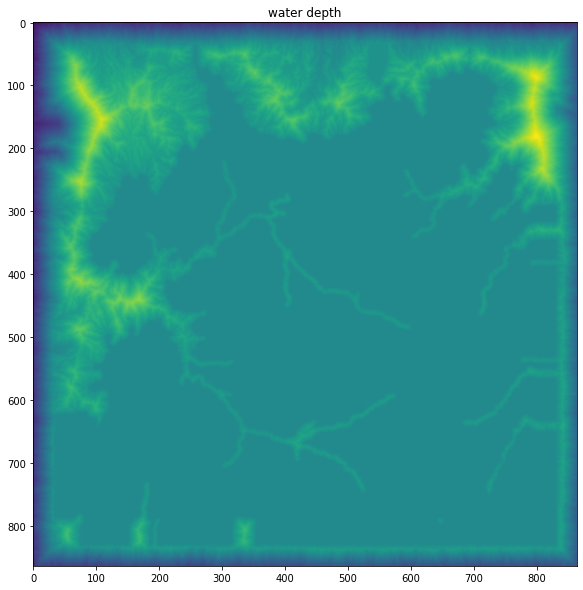

INFO:realms:    \---DONE
INFO:realms:----Combining terrain and water heights


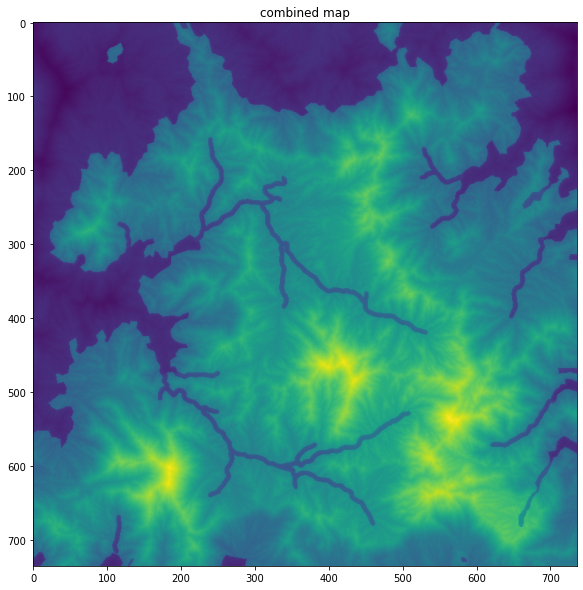

INFO:realms:    \---DONE
INFO:realms:Exporting height map
INFO:realms:    \---DONE
INFO:realms:Coloring
INFO:realms:Injected water pixel at 0, 1.
INFO:realms:    \---DONE
INFO:realms:Exporting color map
INFO:realms:    \---DONE
INFO:realms:Finding index of water tile
DEBUG:realms:water_index: 23
INFO:realms:    \---DONE


In [38]:
config = OmegaConf.load("../pipeline/config.yaml")
debug_hmap = run_pipeline(realm_selection.value, config, debug=True)

In [7]:
from coloring import run_coloring, colorize_perlin
from coloring import moderate, snow, savanna, desert, cold

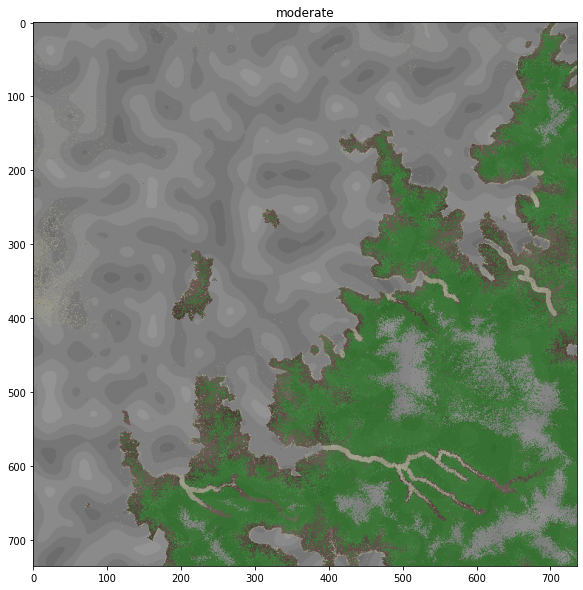

In [21]:
colormap = run_coloring(moderate, debug_hmap)
plt.figure(figsize=(10,10))
plt.title("moderate")
plt.imshow(colormap/255)

In [9]:
raise False

TypeError: exceptions must derive from BaseException

In [ ]:
import sys

from pyvox.parser import VoxParser
from pyvox.writer import VoxWriter
from pyvox.models import Material

import click
import json

donor = VoxParser("../MagicaVoxel-0.99.6.4-win64/vox/donor.vox")
m_donor = donor.parse()

In [ ]:
print([k for k in m_donor.__dict__])

In [ ]:
from struct import unpack_from as unpack, calcsize
cnt = 0
for c in m_donor.remnants:
    if c.id == b"nTRN":
        print(c.__dict__)
        print(c.content[-16:])
        trans = c.content[-16:].split(b"\x00")[-1]
        trans = trans.split(b" ")
        print(trans)
        print(unpack("h", c.content[-2:]))
        cnt += 1
print(cnt)